# Reference

* Research Paper

  <a href="http://proceedings.mlr.press/v15/chu11a.html">Chu, Wei, et al. "Contextual bandits with linear payoff functions." Proceedings of the Fourteenth International Conference on Artificial Intelligence and Statistics. JMLR Workshop and Conference Proceedings, 2011.</a>

* LinUCB Implementation

  https://www.linkedin.com/pulse/contextual-bandits-linear-upper-confidence-bound-disjoint-kenneth-foo



In [59]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize

## 1. LinUCB Function Implementation (May, 2021)

In [ ]:
def generate_kfeatures(num_arms, dimension, seed):
  np.random.seed(seed)
  result = np.array([np.random.random(dimension) for i in range(num_arms)]).transpose()
  return result

In [ ]:
K = 10
D = 5
T = 1000
GLOBAL_SEED = 100
alpha = 0.5

def init_matrix(dimension):
  identity_matrix = []
  for row in range(dimension):
    identity_matrix.append([1 if row==i else 0 for i in range(dimension)])

  identity_matrix = np.array(identity_matrix,dtype=np.float)
  zero_vector = np.zeros((dimension,1))

  return identity_matrix, zero_vector

In [ ]:
def get_reward(obs, arm, theta):
  return obs[:,arm].reshape(1,-1).dot(theta)

In [ ]:
K = 10
D = 5
T = 1000
GLOBAL_SEED = 100
alpha = 0.5

def init_matrix(dimension):
  identity_matrix = []
  for row in range(dimension):
    identity_matrix.append([1 if row==i else 0 for i in range(dimension)])

  identity_matrix = np.array(identity_matrix,dtype=np.float)
  zero_vector = np.zeros((dimension,1))

  return identity_matrix, zero_vector

In [ ]:
A,b = init_matrix(D)

opt_theta = np.random.rand(D)*2-1

est_rewards = list()
opt_rewards = list()

regrets = list()

for t in range(T):
  est_theta = np.linalg.inv(A).dot(b)
  observations = generate_kfeatures(K,D,GLOBAL_SEED+t)

  list_est = []
  list_opt = []
  
  for a in range(K):
    X_ = observations[:,a].reshape(-1,1)
    est_p = est_theta.T.dot(X_) + alpha * np.sqrt(X_.T.dot(np.linalg.inv(A)).dot(X_))
    opt_p = opt_theta.T.dot(X_) + alpha * np.sqrt(X_.T.dot(np.linalg.inv(A)).dot(X_))

    list_est.append(est_p.item())
    list_opt.append(opt_p.item())

  est_arm = np.argmax(list_est)
  opt_arm = np.argmax(list_opt)

  est_reward = get_reward(observations, est_arm, opt_theta)
  opt_reward = get_reward(observations, opt_arm, opt_theta)

  A += observations[:,est_arm].reshape(-1,1).dot(observations[:,est_arm].reshape(1,-1))
  b += (observations[:,est_arm] * est_reward).reshape(-1,1)

  regrets.append(observations[:,opt_arm].reshape(1,-1).dot(opt_theta)-observations[:,est_arm].reshape(1,-1).dot(est_theta))

  print(f"Iter:{t+1} | Reward: EST:{est_reward.item():.4f}/OPT:{opt_reward.item():.4f} | Regret:{sum(regrets).item():.4f}")

Iter:1 | Reward: EST:-0.2695/OPT:0.2343 | Regret:0.2343
Iter:2 | Reward: EST:-0.2286/OPT:-0.2286 | Regret:0.1594
Iter:3 | Reward: EST:-0.9038/OPT:-0.0145 | Regret:0.2951
Iter:4 | Reward: EST:-0.6729/OPT:0.0930 | Regret:0.6214
Iter:5 | Reward: EST:0.1376/OPT:0.1376 | Regret:1.0419
Iter:6 | Reward: EST:0.1349/OPT:0.1349 | Regret:1.3395
Iter:7 | Reward: EST:0.2141/OPT:0.2141 | Regret:1.7321
Iter:8 | Reward: EST:0.2408/OPT:0.2408 | Regret:1.9773
Iter:9 | Reward: EST:0.4079/OPT:0.4079 | Regret:2.2948
Iter:10 | Reward: EST:0.0174/OPT:0.0174 | Regret:2.4167
Iter:11 | Reward: EST:0.1074/OPT:0.1074 | Regret:2.4975
Iter:12 | Reward: EST:-0.3839/OPT:-0.1049 | Regret:2.5699
Iter:13 | Reward: EST:0.6047/OPT:0.6047 | Regret:2.9325
Iter:14 | Reward: EST:0.6116/OPT:0.6116 | Regret:3.2272
Iter:15 | Reward: EST:0.0064/OPT:0.0064 | Regret:3.2187
Iter:16 | Reward: EST:-0.0555/OPT:-0.0555 | Regret:3.1640
Iter:17 | Reward: EST:0.4604/OPT:0.4604 | Regret:3.3608
Iter:18 | Reward: EST:-0.0449/OPT:-0.0449 | Reg

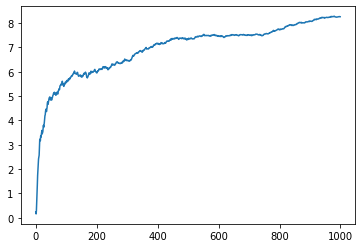

In [ ]:
import pandas as pd

pd.Series(np.cumsum(regrets)).plot()

## 2. LinUCB Class Implementation w/ env contained (June, 2021)

In [ ]:
class LinUCB:
  def __init__(self, k, d, t, alpha, seed):
    self.k = k 
    self.d = d
    self.t = t
    self.alpha = alpha
    self.seed = seed

    self.opt_theta = np.random.rand(d)*2-1

  def init_matrix(self):
    identity_matrix = []
    for row in range(self.d):
      identity_matrix.append([1 if row==i else 0 for i in range(self.d)])

    identity_matrix = np.array(identity_matrix,dtype=np.float)
    zero_vector = np.zeros((self.d,1))

    return identity_matrix, zero_vector

  def generate_features(self, idx):
    np.random.seed(self.seed+idx)
    result = np.array([np.random.random(self.d) for i in range(self.k)]).transpose()
    return result

  def get_reward(self, obs, arm):
    return obs[:,arm].reshape(1,-1).dot(self.opt_theta)

  def pulling_arms(self, observations, A, est_theta):
    list_est = []
    list_opt = []
    
    for a in range(self.k):
      X_ = observations[:,a].reshape(-1,1)
      est_p = est_theta.T.dot(X_) + self.alpha * np.sqrt(X_.T.dot(np.linalg.inv(A)).dot(X_))
      opt_p = self.opt_theta.T.dot(X_) + self.alpha * np.sqrt(X_.T.dot(np.linalg.inv(A)).dot(X_))

      list_est.append(est_p.item())
      list_opt.append(opt_p.item())

    est_arm = np.argmax(list_est)
    opt_arm = np.argmax(list_opt)

    return est_arm, opt_arm

  def predict(self):
    A,b = self.init_matrix()

    est_rewards = list()
    opt_rewards = list()

    regrets = list()

    for t in range(self.t):
      est_theta = np.linalg.inv(A).dot(b)
      observations = self.generate_features(t)
      
      est_arm, opt_arm = self.pulling_arms(observations, A, est_theta)

      est_reward = self.get_reward(observations, est_arm)
      opt_reward = self.get_reward(observations, opt_arm)

      A += observations[:,est_arm].reshape(-1,1).dot(observations[:,est_arm].reshape(1,-1)) 
      b += (observations[:,est_arm] * est_reward).reshape(-1,1)

      regrets.append(observations[:,opt_arm].reshape(1,-1).dot(self.opt_theta)-observations[:,est_arm].reshape(1,-1).dot(est_theta))

      print(f"Iter:{t+1} | Reward: EST:{est_reward.item():.4f}/OPT:{opt_reward.item():.4f} | Regret:{sum(regrets).item():.4f}")

    self.regret = regrets

  def plot_regret(self):
    pd.Series(np.cumsum(self.regret)).plot()

Streaming output truncated to the last 5000 lines.
Iter:5001 | Reward: EST:0.1488/OPT:0.1488 | Regret:9.3588
Iter:5002 | Reward: EST:0.3015/OPT:0.3015 | Regret:9.3600
Iter:5003 | Reward: EST:0.0959/OPT:0.0959 | Regret:9.3592
Iter:5004 | Reward: EST:0.0422/OPT:0.0422 | Regret:9.3586
Iter:5005 | Reward: EST:0.5260/OPT:0.5260 | Regret:9.3612
Iter:5006 | Reward: EST:-0.0563/OPT:-0.0563 | Regret:9.3589
Iter:5007 | Reward: EST:0.2274/OPT:0.2274 | Regret:9.3591
Iter:5008 | Reward: EST:0.3903/OPT:0.3903 | Regret:9.3608
Iter:5009 | Reward: EST:0.2835/OPT:0.2835 | Regret:9.3620
Iter:5010 | Reward: EST:0.2236/OPT:0.2340 | Regret:9.3725
Iter:5011 | Reward: EST:-0.1471/OPT:-0.1471 | Regret:9.3709
Iter:5012 | Reward: EST:0.0878/OPT:0.0878 | Regret:9.3708
Iter:5013 | Reward: EST:0.2836/OPT:0.2836 | Regret:9.3709
Iter:5014 | Reward: EST:0.1721/OPT:0.1721 | Regret:9.3709
Iter:5015 | Reward: EST:0.1298/OPT:0.1298 | Regret:9.3708
Iter:5016 | Reward: EST:0.2986/OPT:0.2986 | Regret:9.3716
Iter:5017 | Rewar

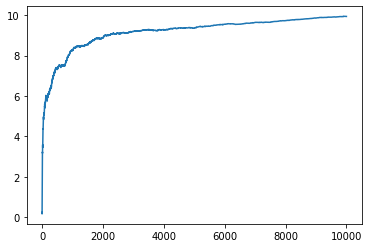

In [ ]:
K = 10
D = 5
T = 10000
GLOBAL_SEED = 100
alpha = 0.5


linucb = LinUCB(K,D,T,alpha,GLOBAL_SEED)
linucb.predict()
linucb.plot_regret()

## 3. LinUCB Class Implementation env seperated (July, 2021)

In [67]:
class Env:
  def __init__(self, k, d, norm=None, random_state=None):
    self.k = k
    self.d = d
    self.norm = norm

    self.seed_initialization(random_state)
    self.true_theta = self.init_theta()

  def init_theta(self):
    if self.norm is not None:
      return normalize(np.random.random((self.d,1)), norm=self.norm, axis=0)
    else:
      return np.random.random((self.d,1))

  def get_observations(self):
    if self.norm is not None:
      return normalize(np.hstack([np.random.random((self.d,1)) for i in range(self.k)]), norm=self.norm, axis=0)
    else:
      return np.hstack([np.random.random((self.d,1)) for i in range(self.k)])

  def seed_initialization(self, random_state):
    np.random.seed(random_state)

In [68]:
class LinUCB:
  def __init__(self, k, d, t, alpha, norm=None, seed=None):
    self.k = k 
    self.d = d
    self.t = t
    self.alpha = alpha

    self.env = Env(k,d, norm=norm, random_state=seed)
    self.opt_theta = self.env.true_theta

  def init_matrix(self):
    identity_matrix = []
    for row in range(self.d):
      identity_matrix.append([1 if row==i else 0 for i in range(self.d)])

    identity_matrix = np.array(identity_matrix,dtype=np.float)
    zero_vector = np.zeros((self.d,1))

    return identity_matrix, zero_vector

  def get_reward(self, obs, arm):
    return obs[:,arm].reshape(1,-1).dot(self.opt_theta)

  def pulling_arms(self, observations, A, est_theta):
    list_est = []
    list_opt = []
    
    for a in range(self.k):
      X_ = observations[:,a].reshape(-1,1)
      est_p = est_theta.T.dot(X_) + self.alpha * np.sqrt(X_.T.dot(np.linalg.inv(A)).dot(X_))
      opt_p = self.opt_theta.T.dot(X_) + self.alpha * np.sqrt(X_.T.dot(np.linalg.inv(A)).dot(X_))

      list_est.append(est_p.item())
      list_opt.append(opt_p.item())

    est_arm = np.argmax(list_est)
    opt_arm = np.argmax(list_opt)

    return est_arm, opt_arm

  def predict(self):
    A,b = self.init_matrix()

    est_rewards = list()
    opt_rewards = list()

    regrets = list()

    for t in range(self.t):
      est_theta = np.linalg.inv(A).dot(b)
      observations = self.env.get_observations()
      
      est_arm, opt_arm = self.pulling_arms(observations, A, est_theta)

      est_reward = self.get_reward(observations, est_arm)
      opt_reward = self.get_reward(observations, opt_arm)

      A += observations[:,est_arm].reshape(-1,1).dot(observations[:,est_arm].reshape(1,-1)) 
      b += (observations[:,est_arm] * est_reward).reshape(-1,1)

      regrets.append(observations[:,opt_arm].reshape(1,-1).dot(self.opt_theta)-observations[:,est_arm].reshape(1,-1).dot(est_theta))

      print(f"Iter:{t+1} | Reward: EST:{est_reward.item():.4f}/OPT:{opt_reward.item():.4f} | Regret:{sum(regrets).item():.4f}")

    self.regret = regrets

  def plot_regret(self):
    pd.Series(np.cumsum(self.regret)).plot()

without l2 normalization

Iter:1 | Reward: EST:1.5374/OPT:1.5374 | Regret:1.5374
Iter:2 | Reward: EST:1.1634/OPT:1.3652 | Regret:2.0430
Iter:3 | Reward: EST:1.5799/OPT:1.8840 | Regret:2.8501
Iter:4 | Reward: EST:1.4634/OPT:1.5607 | Regret:3.2531
Iter:5 | Reward: EST:1.6307/OPT:1.6307 | Regret:3.4642
Iter:6 | Reward: EST:1.5800/OPT:1.7309 | Regret:3.7767
Iter:7 | Reward: EST:1.3018/OPT:1.6944 | Regret:4.0988
Iter:8 | Reward: EST:1.4829/OPT:1.5162 | Regret:4.2086
Iter:9 | Reward: EST:1.6078/OPT:1.6078 | Regret:4.4875
Iter:10 | Reward: EST:0.8726/OPT:1.1157 | Regret:4.5214
Iter:11 | Reward: EST:1.2435/OPT:1.1964 | Regret:4.4907
Iter:12 | Reward: EST:1.5641/OPT:1.5641 | Regret:4.6862
Iter:13 | Reward: EST:1.7312/OPT:1.7312 | Regret:4.8680
Iter:14 | Reward: EST:1.6555/OPT:1.6555 | Regret:4.9395
Iter:15 | Reward: EST:1.4556/OPT:1.4556 | Regret:4.9669
Iter:16 | Reward: EST:1.4996/OPT:1.4996 | Regret:5.0049
Iter:17 | Reward: EST:1.2537/OPT:1.2537 | Regret:4.9726
Iter:18 | Reward: EST:1.5338/OPT:1.5338 | Regret:5.0675
I

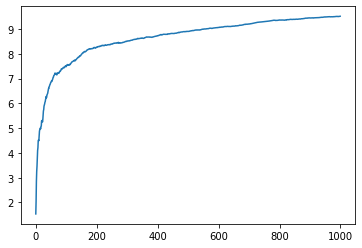

In [70]:
K = 10
D = 5
T = 1000
GLOBAL_SEED = 100
norm = None
alpha = 0.5


linucb = LinUCB(K,D,T,alpha,norm,GLOBAL_SEED)
linucb.predict()
linucb.plot_regret()

with l2 normalization

Iter:1 | Reward: EST:0.5242/OPT:0.9558 | Regret:0.9558
Iter:2 | Reward: EST:0.6029/OPT:0.9343 | Regret:1.6731
Iter:3 | Reward: EST:0.8577/OPT:0.9544 | Regret:2.2938
Iter:4 | Reward: EST:0.8147/OPT:0.9544 | Regret:2.7562
Iter:5 | Reward: EST:0.6511/OPT:0.8798 | Regret:3.1047
Iter:6 | Reward: EST:0.9623/OPT:0.9623 | Regret:3.5149
Iter:7 | Reward: EST:0.9304/OPT:0.9361 | Regret:3.7768
Iter:8 | Reward: EST:0.9810/OPT:0.9810 | Regret:4.0713
Iter:9 | Reward: EST:0.9863/OPT:0.9863 | Regret:4.3426
Iter:10 | Reward: EST:0.9307/OPT:0.9307 | Regret:4.5070
Iter:11 | Reward: EST:0.9181/OPT:0.9181 | Regret:4.6303
Iter:12 | Reward: EST:0.9355/OPT:0.9355 | Regret:4.7681
Iter:13 | Reward: EST:0.9012/OPT:0.9012 | Regret:4.8796
Iter:14 | Reward: EST:0.9684/OPT:0.9684 | Regret:4.9982
Iter:15 | Reward: EST:0.8624/OPT:0.8624 | Regret:5.0698
Iter:16 | Reward: EST:0.8947/OPT:0.8947 | Regret:5.1527
Iter:17 | Reward: EST:0.8545/OPT:0.8545 | Regret:5.2134
Iter:18 | Reward: EST:0.9126/OPT:0.9126 | Regret:5.2857
I

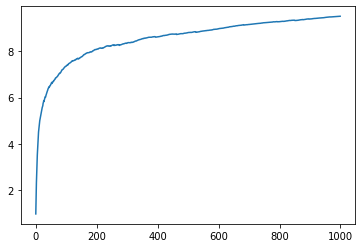

In [71]:
K = 10
D = 5
T = 1000
GLOBAL_SEED = 100
norm = "l2"
alpha = 0.5


linucb = LinUCB(K,D,T,alpha,norm,GLOBAL_SEED)
linucb.predict()
linucb.plot_regret()